# Importing important libraries and activating the GPU

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Embedding, LSTM, Dense, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'{len(physical_devices)} are avilable')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

1 are avilable


# The file spam.csv
## This file has encoding 'ISO-8859-1'
### Dropping the useless columns and renaming the columns
### The labels are maped usign following dictionary {'ham' : 0, 'spam' : 1}

In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [5]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [6]:
df.columns = ['label','message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df['label'] = df['label'].map({'ham':0, 'spam':1})
y = df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], y, test_size=0.3)

# Text processing
## We select the maximum vocabulary size i.e. number of distinct words (tokens) as 20000
### The tokenizer object tokenizes each distinct word by providing a integer value to it by doing fit_on_texts
### These tokens (integers) are used to convert a sentence into a sequence (vector)

### The tokenizer.word_index gives the dictionary where the istinct word is key and assigned integer is value

In [9]:
max_vocab_size = 20000
tokenizer = Tokenizer(num_words = max_vocab_size)
tokenizer.fit_on_texts(X_train)
train_sequence = tokenizer.texts_to_sequences(X_train)
test_sequence = tokenizer.texts_to_sequences(X_test)

In [10]:
word_to_index_dict = tokenizer.word_index
print(f'{len(word_to_index_dict)} number of tokens found')

7466 number of tokens found


# Sequence processing
### Once the sequence is found , it's not always of same length hence we pad them with zeros 
### by default the 0's are added infront , we did it in train sequence
### In test_sequence we set the max length as the length of padded train sequence

In [11]:
train_sequence = pad_sequences(train_sequence)

In [12]:
test_sequence = pad_sequences(test_sequence, maxlen = train_sequence.shape[1])

# Model
### The input is the sequences
### the Embedding layer is very important since it converts these words into vectors which are interpretable i.e. similar words will have greater cosine similarity and vice-versa. The input if number of distinct words +1 and the output representation is 20 dimensional vector. This 20 dimensions is hyperparameter
### The LSTM unit has 15 neurons with tanh activation
### GlobalMaxpooling1D is added
### This is binary classification hence we add 1 neuron in output layer with sigmoid activation

In [13]:
# The embedding vector size is selected 20
# units in LSTM is 15

i = Input(shape = (train_sequence.shape[1],))
o = Embedding((len(word_to_index_dict)+1), 20)(i)
o = LSTM(15, return_sequences=True)(o)
o = GlobalMaxPooling1D()(o)
o = Dense(1, activation = 'sigmoid')(o)

model = Model(i,o)

# Compile and Fit
### We use ADAM as optimizer, binary crossentropy as loss function and accuracy as metric
### The model is trained for 12 epochs

In [14]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [15]:
r = model.fit(train_sequence, y_train, validation_data = (test_sequence, y_test), epochs = 12)

Epoch 1/12
122/122 [==============================] - 5s 17ms/step - loss: 0.4467 - accuracy: 0.8669 - val_loss: 0.3883 - val_accuracy: 0.8636
Epoch 2/12
122/122 [==============================] - 2s 15ms/step - loss: 0.3249 - accuracy: 0.8669 - val_loss: 0.2755 - val_accuracy: 0.8636
Epoch 3/12
122/122 [==============================] - 2s 15ms/step - loss: 0.2309 - accuracy: 0.8669 - val_loss: 0.2069 - val_accuracy: 0.8636
Epoch 4/12
122/122 [==============================] - 2s 16ms/step - loss: 0.1572 - accuracy: 0.9462 - val_loss: 0.1370 - val_accuracy: 0.9761
Epoch 5/12
122/122 [==============================] - 2s 15ms/step - loss: 0.0870 - accuracy: 0.9903 - val_loss: 0.0961 - val_accuracy: 0.9803
Epoch 6/12
122/122 [==============================] - 2s 15ms/step - loss: 0.0475 - accuracy: 0.9941 - val_loss: 0.0753 - val_accuracy: 0.9839
Epoch 7/12
122/122 [==============================] - 2s 15ms/step - loss: 0.0299 - accuracy: 0.9967 - val_loss: 0.0655 - val_accuracy: 0.9868

# History plotter function

###  This plots the history object with argument as 'loss' and 'accuracy'

In [19]:
def history_printer(model, argument):
    plt.plot(model.history[argument], label = argument)
    plt.plot(model.history['val_'+argument], label = "val_"+argument)
    plt.xlabel('Epoch')
    plt.ylabel(argument)
    plt.legend()

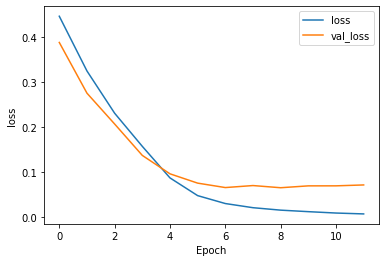

In [20]:
history_printer(r, 'loss')

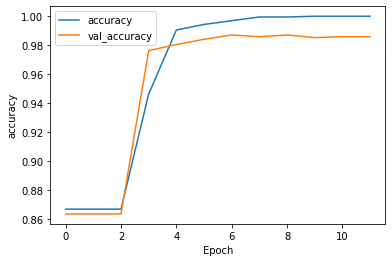

In [21]:
history_printer(r, 'accuracy')